# 02 Uudiste kogumine Telegrami veebilehelt

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import pandas as pd
from wordcloud import WordCloud
from estnltk import Text

Telegrami veebilehtelt  https://www.telegram.ee/arhiiv koguti veebiämblikuga uudisartiklite lingid. Kogutud lingid on failis:  telegram/telegram/spiders/telegram_rubriigid_arhiiv.csv 

Linkide kogumiseks kasutatud valikukriteeriumid:

Rubriigid:

•	Arvamus 

•	Eesti 

•	Maailm 

•	New World Order

•	Teadus- ja tulevik 

In [47]:
# Telegrami veebilehelt veebiämblikuga kogutud lingid loetakse listi

# list Telegrami linkide jaoks
urls_telegram_toor = []

with open('telegram/telegram/spiders/telegram_rubriigid_arhiiv.csv', 'r', encoding = 'utf-8') as f:
    reader = csv.reader(f)
    for line in reader:
        if line != []:
            urls_telegram_toor.append(line[0])
# linkide failis esimene rida ei ole uudise link
print(len(urls_telegram_toor)-1)

6439


In [48]:
# võimalike topeltlinkide eemaldamine

urls_telegram_e = list(dict.fromkeys(urls_telegram_toor))

print("Telegrami veebilehtedelt kogutud linkide arv: ", len(urls_telegram_e)-1)

Telegrami veebilehtedelt kogutud linkide arv:  5084


In [50]:
# Filtreeritakse välja ainult www.telegram.ee lingid
urls_telegram = []
telegram = 'https://www.telegram.ee/'
for link in urls_telegram_e:
    if telegram in link:
        urls_telegram.append(link)
print('Telegrami veebilehtedelt kogutud linkide arv: ', len(urls_telegram))

Telegrami veebilehtedelt kogutud linkide arv:  5081


Telegrami veebilehtedelt kogutud linkidelt saadakse BeautifulSoup abil järgmine info:

1) väljaande nimi

2) artikli pealkiri

3) artikli tekst

4) artikli publitseerimise kuupäev

In [12]:
headers = requests.utils.default_headers()
headers.update(
  { 'User-Agent': 'my crawler (anneliis@ut.ee) / on studying purpose', }
)
pealkirjad = []
tekstid = []
väljaanded = []
ajad =[]

for url in tqdm(urls_telegram):
    try:
        page = requests.get(url)

        soup = BeautifulSoup(page.content, "html.parser")
        pealkiri = soup.find("meta", {"property" : "og:title"})['content']
        väljaanne = soup.find("meta", {"property" : "og:site_name"})['content']
        aeg = soup.find("meta", {"property" : "article:published_time"})['content']

        results = soup.find("div", attrs = {"class" : "left articlecontent"})
        artikkel = results.find_all("div")

        for art in artikkel:
            loik = art.find_all("p")
            for l in loik:
                tekst = l.text.replace('\n',' ')
                tekst = tekst.replace('\xa0',' ')
                break
        tekstid.append(tekst.strip())
    except Exception as e:
        print("Exception is :", e, url)   

    pealkirjad.append(pealkiri)
    väljaanded.append(väljaanne)
    ajad.append(aeg)

100%|████████████████████████████████████████████████████████████████████████████| 5081/5081 [1:29:07<00:00,  1.05s/it]


Kogutud info uudisartiklite kohta koondatakse sõnastikuks.

In [31]:
artiklid = {'title': pealkirjad, 'text': tekstid,'subject': väljaanded, 'date': ajad, 'link': urls_telegram}

Kogutud sõnastik esitatakse tabeli kujul. Tabelis on viis veergu:

1) artikli pealkiri

2) artikli tekst

3) artikli väljaandja

4) artikli publitseerimise kuupäev

5) artikli link

In [32]:
data_telegram_rubriigid = pd.DataFrame(artiklid, columns = ['title', 'text','subject', 'date', 'link'])

In [34]:
data_telegram_rubriigid.shape

(5081, 5)

Järgnevalt filtreeritakse välja tühjade väljadega uudisartiklid.

In [35]:
data_telegram_rubriigid.dropna(inplace=True)

In [36]:
data_telegram_rubriigid.shape

(5081, 5)

In [37]:
data_telegram_rubriigid = data_telegram_rubriigid[(data_telegram_rubriigid.text != '') & (data_telegram_rubriigid.title != '') & (data_telegram_rubriigid.subject != '') & (data_telegram_rubriigid.date != '') ]

In [38]:
data_telegram_rubriigid.shape

(5074, 5)

subject
Telegram    5074
Name: text, dtype: int64


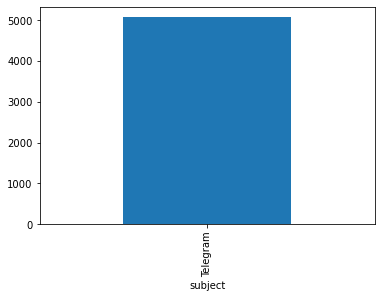

In [40]:
# Artiklite jaotus väljaandjate kaupa
print(data_telegram_rubriigid.groupby(['subject'])['text'].count())
data_telegram_rubriigid.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

In [41]:
data_telegram_rubriigid.to_csv('data_telegram_UUS.csv',index=False)

## Sõnapilvede loomine

In [42]:
#https://et.wikipedia.org/wiki/Sides%C3%B5na
#https://www.taskutark.ee/m/asesonad/
#sidesõnad
stopsõnad = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni']
#sidesõnad ja asesõnad
stopsõnad_uus = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni', 'siis', 'ka', 'nii', 'kas',
             'mina', 'ma', 'meie', 'me', 'sina', 'sa', 'teie', 'te', 'tema', 'ta', 'nemad', 'nad',
             'enese', 'enda', 'iseenese', 'iseenda', 'oma', 'üksteise', 'teineteise',
             'see', 'too', 'sama', 'seesama', 'toosama', 'teine', 'muu',
             'niisugune', 'samasugune', 'niisamasugune', 'selline', 'seesugune', 'säärane','säherdune', 
             'taoline', 'selletaoline', 'kes', 'mis', 'kumb', 'missugune', 'milline', 'misuke', 'mitu', 'mitmes', 'mitmendik',
             'ise', 'oma', 'iga', 'igaüks', 'igamees', 'kõik', 'mõlemad', 'kumbki', 'emb-kumb', 'kogu', 'terve',
             'keegi', 'miski', 'mingi', 'mingisugune', 'miskisugune', 'ükski', 'mitu', 'mitmes', 'mitu-setu', 'mitmes-setmes',
             'mõni', 'mõningane', 'paljud', 'üks', 'teine', 'oma', 'enese', 'enda', 'omaenese', 'omaenda', 'iseoma', 
             'iseenese', 'iseenda', 'emb', 'mõlema', 'palju']

## Nimi- ja omadussõnade kasutamine

EstNLTK vahenditega vaadeldakse Telegrami uudistes esinevate sõnade lemmasid ja sõnade liike. Edaspidiseks vaatluseks eraldatakse nimisõnad (sõnaliik S) ja omadussõnad (sõnaliigid A - algvõrre, C - keskvõrre, U - ülivõrre).

In [52]:
# Telegrami uudistes nimisõnade ja omadussõnade kasutamine
nimi_omadus_sonad = []
for i in tqdm(range (0, len(data_telegram_rubriigid))):
    rida = data_telegram_rubriigid.iloc[i]
    tekst = Text(rida[1]).tag_layer().morph_analysis['lemma','partofspeech']
    for sona in tekst:
        if sona[0][1] == 'S' or sona[0][1] == 'A' or sona[0][1] == 'C' or sona[0][1] == 'U':
            nimi_omadus_sonad.append(sona[0][0])

nimi_omadus_words = ' '.join(map(str, nimi_omadus_sonad))

100%|██████████████████████████████████████████████████████████████████████████████| 5074/5074 [24:53<00:00,  3.40it/s]


Nimisõnu ja omadussõnu sõnapilves:  938757


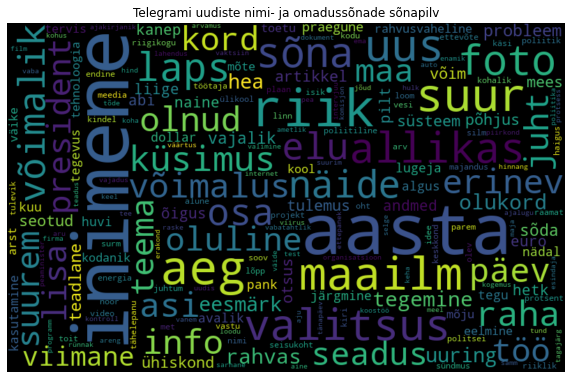

In [53]:
wordcloud_nimi_omadus = WordCloud(stopwords = stopsõnad_uus, width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(nimi_omadus_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_nimi_omadus, interpolation='bilinear')
plt.title("Telegrami uudiste nimi- ja omadussõnade sõnapilv")
plt.savefig('Telegrami_uudiste_nimi_omadus_sõnapilv_UUS.png')
plt.axis("off")
print("Nimisõnu ja omadussõnu sõnapilves: ", len(nimi_omadus_sonad))

## Nimi- ja omadussõnade esinemissagedus ning osakaal

In [54]:
df_1 =pd.DataFrame(nimi_omadus_sonad, columns=['sõna'])
sagedused_1 = df_1.groupby(['sõna']).size().reset_index(name='esinemissagedus').sort_values(by='esinemissagedus', ascending=False)[:10]
sagedused_1['osakaal %']= (sagedused_1['esinemissagedus']/len(nimi_omadus_sonad)*100)

In [55]:
print("Telegrami uudiste nimisõnade ja omadussõnade TOP 10")
sagedused_1

Telegrami uudiste nimisõnade ja omadussõnade TOP 10


,sõna,esinemissagedus,osakaal %
15122,inimene,15325,1.632478
1631,aasta,12703,1.353172
46296,riik,5840,0.622099
1961,aeg,4899,0.521860
50885,suur,4653,0.495655
30123,maailm,4502,0.479570
58997,uus,4288,0.456774
60007,valitsus,4203,0.447720
2998,allikas,3966,0.422474
51559,sõna,3774,0.402021


## Verbide kasutamine

In [45]:
verb_sonad = []
for i in tqdm(range (0, len(data_telegram_rubriigid))):
    rida = data_telegram_rubriigid.iloc[i]
    tekst = Text(rida[1]).tag_layer().morph_analysis['lemma','partofspeech']
    for sona in tekst:
        if sona[0][1] == 'V':
            verb_sonad.append(sona[0][0])

verb_words = ' '.join(map(str, verb_sonad))

100%|██████████████████████████████████████████████████████████████████████████████| 5074/5074 [24:28<00:00,  3.46it/s]


Verbe sõnapilves:  471601


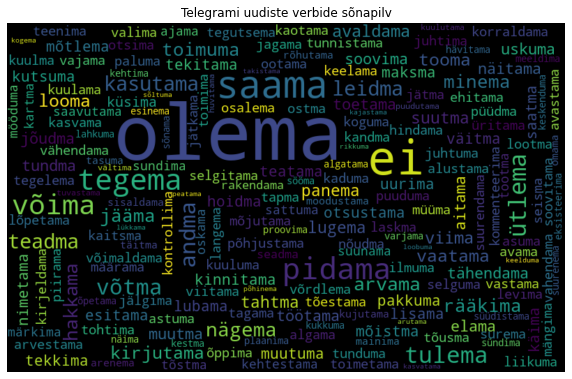

In [46]:
wordcloud_verb = WordCloud(stopwords = stopsõnad_uus, width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(verb_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_verb, interpolation='bilinear')
plt.title("Telegrami uudiste verbide sõnapilv")
plt.savefig('Telegrami_uudiste_sõnapilv_verb_sonad_UUS.png')
plt.axis("off")
print("Verbe sõnapilves: ", len(verb_sonad))

## Verbide esinemissagedus ja osakaal

In [56]:
df_2 =pd.DataFrame(verb_sonad, columns=['sõna'])
sagedused_2 = df_2.groupby(['sõna']).size().reset_index(name='esinemissagedus').sort_values(by='esinemissagedus', ascending=False)[:10]
sagedused_2['osakaal %']= (sagedused_2['esinemissagedus']/len(verb_sonad)*100)

In [57]:
print("Telegrami uudiste verbide TOP 10")
sagedused_2

Telegrami uudiste verbide TOP 10


,sõna,esinemissagedus,osakaal %
1778,olema,108854,23.081800
252,ei,26120,5.538580
2302,saama,15259,3.235574
1918,pidama,9181,1.946773
2693,tegema,8855,1.877647
3192,võima,8010,1.698470
3303,ütlema,5651,1.198259
2832,tulema,5375,1.139735
84,andma,5185,1.099446
3218,võtma,4710,0.998726
